# Planetary Training

OBS: This notebook is for running in the MSPC only!!!!

In [1]:
%load_ext autoreload
%autoreload 2

from waternet.wndataset import WNDataSet
from fastai.vision.all import *


### Creating the Datasets

In [2]:
masks_path = '/home/jovyan/tmp3'
training_bands = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
# masks_path='d:/temp/22KEV/'

In [3]:
# default config for shape, size and step
config = dict(
    shape=(5490, 5490),
    patch_size=(512, 512),
    step=262,    
)

# 2018 october for training
train_ds = WNDataSet.from_masks(
    masks_path=masks_path,
    pattern='*S2A*watermask.tif',
    **config
)

Matching imgs/masks:   0%|          | 0/106 [00:00<?, ?it/s]

In [4]:
len(train_ds)

42400

In [5]:
# a single image for the validation
valid_ds = WNDataSet.from_masks(
    masks_path=masks_path,
    pattern='*S2B_MSIL2A_2021*watermask.tif',
    **config
)

Matching imgs/masks:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
train_ds.bands = training_bands
valid_ds.bands = training_bands

print(train_ds)
print(valid_ds)

WNDataset instance with 106 images
Loaded: 0 items
Empty: 106 items
Loading: 0 items

WNDataset instance with 25 images
Loaded: 0 items
Empty: 25 items
Loading: 0 items



### Creating Dataloaders

In [7]:
# Create two dataloaders (for training and validation)
# Put it in the GPU
dls = DataLoaders(
    DataLoader(train_ds, bs=8),
    DataLoader(valid_ds, bs=8)
).cuda()

In [8]:
m, t = dls.valid.one_batch()
m.device

Loading image 1 in background


device(type='cuda', index=0)

In [9]:
dls.train.one_batch()[0].shape

Loaded sucessfully
Loading image 1 in background


torch.Size([8, 6, 512, 512])

### Creating the Learner

In [10]:
learner = unet_learner(
    dls, arch=resnet18, pretrained=False, normalize=False, n_in=6, n_out=3, loss_func=CrossEntropyLossFlat(axis=1)
)
cuda_model = learner.cuda()

/srv/conda/envs/notebook/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Checking model and predictions

In [27]:
learner.summary()

DynamicUnet (Input shape: 12 x 6 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     12 x 64 x 256 x 256 
Conv2d                                    18816      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     12 x 64 x 128 x 128 
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                     

In [28]:
batch, target = dls.train.one_batch()
print(batch.shape, target.shape)

torch.Size([12, 6, 512, 512]) torch.Size([12, 512, 512])


In [29]:
# Calculate the predictions for the 4 patches (1 batch)
# pred = learner.model(batch)
# pred.shape

torch.Size([12, 3, 512, 512])

In [31]:
# CrossEntropyLossFlat(axis=1)(pred, target)

TensorBase(1.2200, device='cuda:0', grad_fn=<AliasBackward0>)

### Running LrFind

Up to now, evertying was done in the CPU, but to run large amounts, it is necessary to load the data in the Cuda device. For that we will put them in the GPU and find the best learning rate.

Loaded sucessfully
Cleared image 0
Loading image 2 in background
Loaded sucessfully


SuggestedLRs(valley=3.0199516913853586e-05)

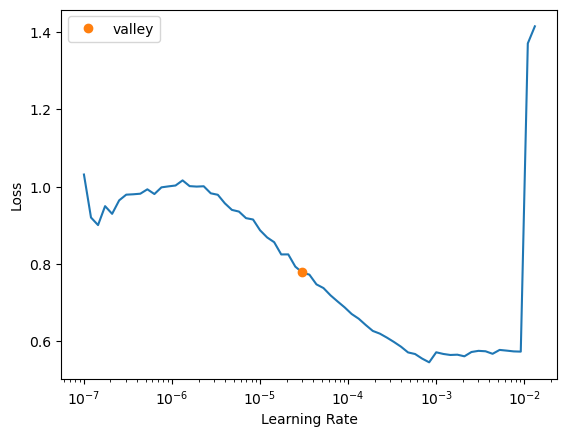

In [11]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(1, lr_max=1e-4)

epoch,train_loss,valid_loss,time


In [13]:
learner.model_dir

'models'

In [14]:
learner.save('first_model')

Path('models/first_model.pth')

### Como ver os resultados???

In [ ]:
learner